Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import Sequential

import pathlib

Parameters

In [3]:
img_height, img_width = 300, 300
batch_size = 32

# Load images from directory and split into training and validation sets
data_dir = pathlib.Path("../data")
all_data = []

Collecting Data from the data Folder

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2160


Split the Data into Training and Validation Sets

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2160 files belonging to 54 classes.
Using 1728 files for training.
Found 2160 files belonging to 54 classes.
Using 432 files for validation.


Visualising Data

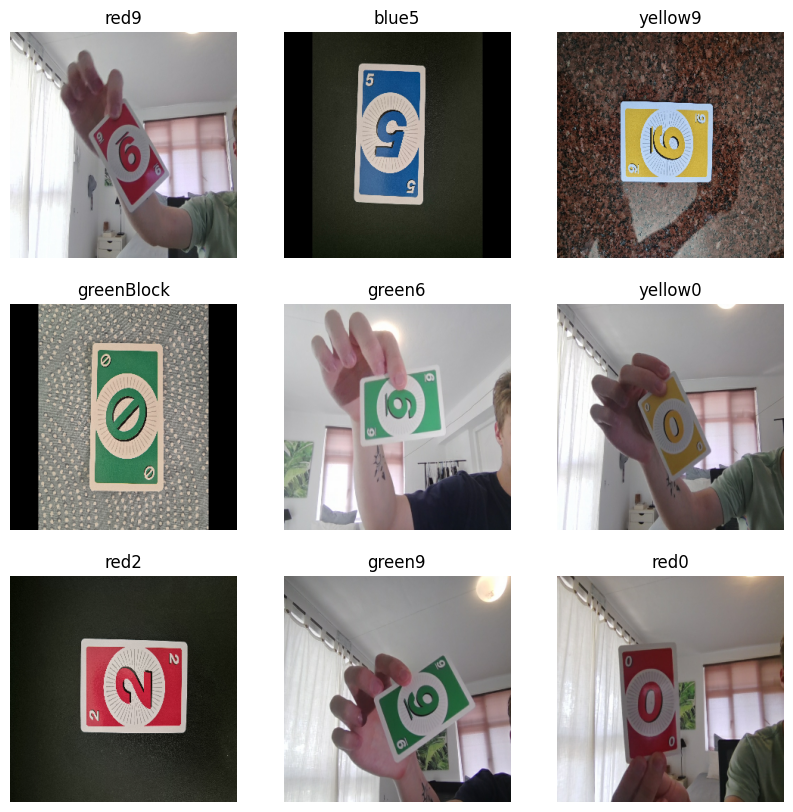

In [6]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure the Dataset for Performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardizing the Data

In [8]:
normalization_layer = layers.Rescaling(1./255)

Augmenting the Data
(Generates additional training data from the existing examples by augmenting them using random transformations that yield believable-looking images)

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\Adolf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Creating the Model

Note that this Model has three convolustion blocks (tf.keras.layers.Conv2D) and a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). Dropout is included to prevent overfitting of the model.

In [10]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Compiling the Model

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Summary (Viewing all the layers of the Network)

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 54)             │         6,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,245,526 (42.90 MB)

 Trainable params: 11,245,526 (42.90 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model (Epochs adjusted to be on a level where we are not overtraining).

In [13]:
epochs = 200

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.0179 - loss: 5.7753 - val_accuracy: 0.0116 - val_loss: 3.9898
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.0136 - loss: 3.9878 - val_accuracy: 0.0116 - val_loss: 3.9731
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.0243 - loss: 3.9243 - val_accuracy: 0.0486 - val_loss: 3.7915
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.0440 - loss: 3.6832 - val_accuracy: 0.0532 - val_loss: 3.4720
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.1181 - loss: 3.2999 - val_accuracy: 0.0972 - val_loss: 3.2817
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.1186 - loss: 3.1797 - val_accuracy: 0.1204 - val_loss: 3.0489
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.1394 - loss: 2.9149 - val_accuracy: 0.1250 - val_loss: 2.8966
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.1676 - loss: 2.7525 - 

Visualizing Training Results

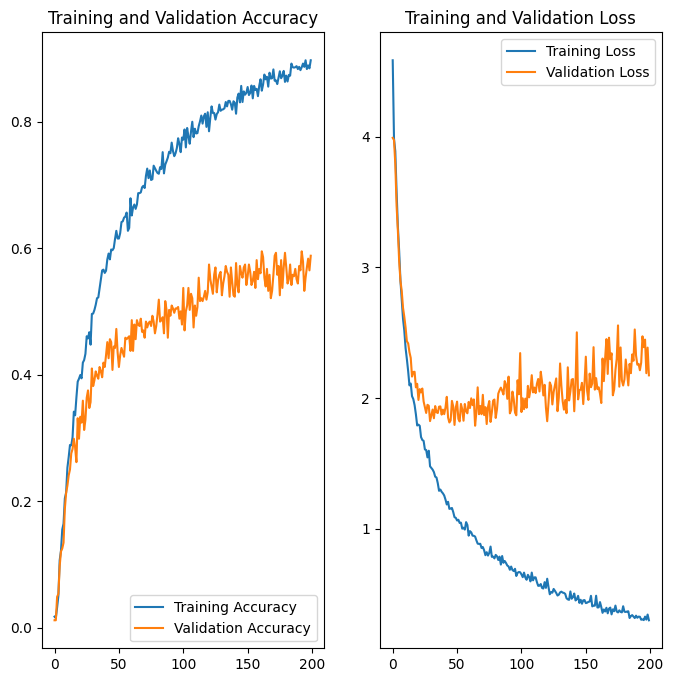

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

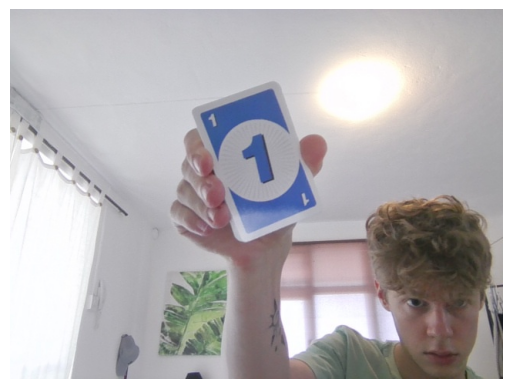

In [15]:
card_path = '../testing_data/blue1.jpg'

# Load and display the image
img =plt.imread(card_path)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

Predicting on New Data

In [16]:
img = tf.keras.utils.load_img(
    card_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This image most likely belongs to blue3 with a 69.75 percent confidence.
